# Importing Necessary Libraries


In [245]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier



# Load imbalanced dataset and display top 5 samples


In [248]:
df=pd.read_csv('StudentPerformanceFactors.csv')

df.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


# Extract Dependent and Independent variable

In [251]:
y=df.iloc[:,-1]
x=df.iloc[:,:-1]

# Preprocessing the datset

In [254]:
mapping={'Low':1,'Medium':2,'High':3}


df['Parental_Invovlement']=df['Parental_Involvement'].map({'Low':1,'Medium':2,'High':3})

df['Access_to_Resources']=df['Access_to_Resources'].map(mapping)
df['Motivation_Level']=df['Motivation_Level'].map(mapping)
df['Family_Income']=df['Family_Income'].map(mapping)
df['Teacher_Quality']=df['Teacher_Quality'].map(mapping)
df['Peer_Influence']=df['Peer_Influence'].map({'Negative':0,'Neutral':1,'Positive':2})
df['Distance_from_Home']=df['Distance_from_Home'].map({'Near':0,'Moderate':1,'Far':2})
df['Parental_Involvement']=df['Parental_Involvement'].map(mapping)

df=df.dropna()


In [256]:
df=df.drop(columns=['Gender','Parental_Education_Level','Learning_Disabilities','School_Type','Internet_Access','Extracurricular_Activities'])

In [258]:
df['Grade'] = pd.cut(
    df['Exam_Score'],
    bins=[0, 50, 65, 80, 100],
    labels=['Fail', 'Pass', 'Good', 'Excellent']
)


In [259]:
x=df.iloc[:,:-1]
y=df['Grade']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [262]:
scaler=StandardScaler()
x_scaled = scaler.fit_transform(x)

x=x.drop('Exam_Score',axis=1)


# Split dataset into training and testing data

In [265]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,random_state=42)

# Train logistic regression using both One Vs Rest and multinomial strategies. 

In [268]:
ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=500))

ovr_model.fit(x_train, y_train)

y_pred_ovr = ovr_model.predict(x_test)


In [270]:
multi_model = LogisticRegression(solver='lbfgs',max_iter=500,random_state=42)
multi_model.fit(x_train,y_train)
y_pred_multi = multi_model.predict(x_test)

# Classification Report

In [273]:
print("OVR Accuracy:", accuracy_score(y_test, y_pred_ovr))
print(classification_report(y_test, y_pred_ovr))

print("Multinomial Accuracy:", accuracy_score(y_test, y_pred_multi))
print(classification_report(y_test, y_pred_multi))


OVR Accuracy: 0.9830721003134796
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.98      0.99      0.99      1065
           2       0.99      0.97      0.98       519

    accuracy                           0.98      1595
   macro avg       0.88      0.84      0.86      1595
weighted avg       0.98      0.98      0.98      1595

Multinomial Accuracy: 0.9987460815047022
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       1.00      1.00      1.00      1065
           2       1.00      1.00      1.00       519

    accuracy                           1.00      1595
   macro avg       1.00      0.94      0.97      1595
weighted avg       1.00      1.00      1.00      1595



# Balancing Dataset

In [276]:
import pandas as pd

x_train = pd.DataFrame(x_train)
y_train = pd.Series(y_train, name='Grade')

train_df = pd.concat([x_train, y_train], axis=1)


In [278]:



# Combine X and y for resampling
train_df = pd.concat([x_train, pd.Series(y_train, name='Grade')], axis=1)

max_size = train_df['Grade'].value_counts().max()

balanced_train = []

for label in train_df['Grade'].unique():
    
    class_subset = train_df[train_df['Grade'] == label]
    
    upsampled = resample(
        class_subset,
        replace=True,
        n_samples=max_size,
        random_state=42
    )
    
    balanced_train.append(upsampled)

balanced_train_df = pd.concat(balanced_train)


In [280]:
X_train_bal = balanced_train_df.drop('Grade', axis=1)
y_train_bal = balanced_train_df['Grade']


In [282]:
print(y_train_bal.value_counts())


Grade
1    3224
2    3224
0    3224
3    3224
Name: count, dtype: int64


In [302]:
print(y_train.value_counts())

Grade
1    3224
2    1527
0      31
3       1
Name: count, dtype: int64


In [284]:
ovr_bal = OneVsRestClassifier(LogisticRegression(max_iter=500))
ovr_bal.fit(X_train_bal, y_train_bal)

y_pred_ovr_bal = ovr_bal.predict(x_test)


In [286]:
multi_model = LogisticRegression(solver='lbfgs',max_iter=500,random_state=42)
multi_model.fit(X_train_bal,y_train_bal)
y_pred_multi_bal = multi_model.predict(x_test)

In [293]:
print("OVR Accuracy:", accuracy_score(y_test, y_pred_ovr_bal))
print(classification_report(y_test, y_pred_ovr_bal))

print("Multinomial Accuracy:", accuracy_score(y_test, y_pred_multi_bal))
print(classification_report(y_test, y_pred_multi_bal))


OVR Accuracy: 0.9793103448275862
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       0.99      0.98      0.98      1065
           2       0.96      0.98      0.97       519

    accuracy                           0.98      1595
   macro avg       0.91      0.99      0.95      1595
weighted avg       0.98      0.98      0.98      1595

Multinomial Accuracy: 0.9987460815047022
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      1.00      1.00      1065
           2       1.00      1.00      1.00       519

    accuracy                           1.00      1595
   macro avg       0.95      1.00      0.97      1595
weighted avg       1.00      1.00      1.00      1595



# Graph

In [298]:
ovr_imbal_acc = 0.9830721003134796
multi_imbal_acc = 0.9987460815047022
ovr_bal_acc = 0.9793103448275862
multi_bal_acc = 0.9987460815047022


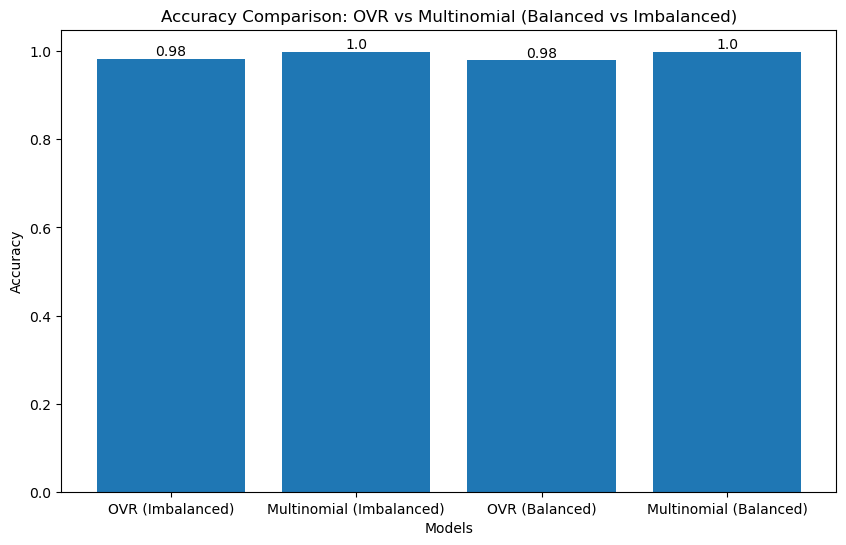

In [300]:
import matplotlib.pyplot as plt

models = [
    'OVR (Imbalanced)',
    'Multinomial (Imbalanced)',
    'OVR (Balanced)',
    'Multinomial (Balanced)'
]

accuracies = [
    ovr_imbal_acc,
    multi_imbal_acc,
    ovr_bal_acc,
    multi_bal_acc
]

plt.figure(figsize=(10,6))

bars = plt.bar(models, accuracies)

plt.title("Accuracy Comparison: OVR vs Multinomial (Balanced vs Imbalanced)")
plt.xlabel("Models")
plt.ylabel("Accuracy")

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             round(yval,2),
             ha='center', va='bottom')

plt.show()
